In [3]:
# reload libraries

%load_ext autoreload
%autoreload 2

In [5]:
import h5py
import cuml
import os
import gc
import matplotlib.pyplot as plt
import numpy as np
import zstandard as zstd
import sklearn
import json
import sys
import pandas as pd
sys.path.append('../')

from src.utils.plots import compute_plot_trutworthiness, extract_statistics_from_folder, match_and_compute_cluster_metrics, load_vectors


# Some data analysis

In [3]:
# what attributes do we have in the dataset

results = []
with open("../data/RS_2017-08.zst", "rb") as file_handle:
    # Setup decompressor with a large max_window_size for large files
    decompressor = zstd.ZstdDecompressor(max_window_size=2147483648)
    reader = decompressor.stream_reader(file_handle)

    while True:
        chunk = reader.read(2**27)

        try:
            data = chunk.decode("utf-8").split("\n")
        except UnicodeDecodeError:
            continue
        
        for line in data:
            # print json with identation
            json.dump(json.loads(line), sys.stdout, indent=4)
            
            break
        break

{
    "archived": false,
    "author": "[deleted]",
    "author_flair_css_class": null,
    "author_flair_text": null,
    "brand_safe": true,
    "contest_mode": false,
    "created_utc": 1501545600,
    "distinguished": null,
    "domain": "youtube.com",
    "edited": false,
    "gilded": 0,
    "hidden": false,
    "hide_score": false,
    "id": "6qsieu",
    "is_crosspostable": false,
    "is_self": false,
    "is_video": false,
    "link_flair_css_class": "viD",
    "link_flair_text": "[VoD] -- Developer response",
    "locked": false,
    "media": {
        "oembed": {
            "author_name": "ZakonACinfo",
            "author_url": "https://www.youtube.com/user/ZakonACinfo",
            "height": 338,
            "html": "&lt;iframe width=\"600\" height=\"338\" src=\"https://www.youtube.com/embed/eCvcEuE7D3o?feature=oembed\" frameborder=\"0\" allowfullscreen&gt;&lt;/iframe&gt;",
            "provider_name": "YouTube",
            "provider_url": "https://www.youtube.com/",
  

In [26]:
df = extract_statistics_from_folder("../data", num_files_to_process=15, subset_fraction=0.1)
df

Processed file: RS_2009-08.zst number of entries: 43519
Processed file: RS_2010-08.zst number of entries: 54231
Processed file: RS_2011-08.zst number of entries: 144543
Processed file: RS_2012-08.zst number of entries: 278849
Processed file: RS_2013-08.zst number of entries: 331439
Processed file: RS_2014-08.zst number of entries: 459737
Processed file: RS_2015-08.zst number of entries: 616435
Processed file: RS_2016-08.zst number of entries: 758121
Processed file: RS_2017-08.zst number of entries: 1041783
Processed file: RS_2018-08.zst number of entries: 1339956
Processed file: RS_2019-08.zst number of entries: 2192329
Processed file: RS_2020-08.zst number of entries: 2889045
Processed file: RS_2021-08.zst number of entries: 2837752
Processed file: RS_2022-08.zst number of entries: 3807368


length  score  num_comments  upvotes  downvotes  has_media  \
0            178      3             3       -1         -1      False   
1             45      6             0       -1         -1      False   
2             36      3             0       -1         -1      False   
3            111      1             0       -1         -1      False   
4             59     19             1       -1         -1      False   
...          ...    ...           ...      ...        ...        ...   
16795102     103      1             0       -1         -1      False   
16795103      37      1             1       -1         -1      False   
16795104      36      1             1       -1         -1       True   
16795105     100      2             1       -1         -1      False   
16795106      80      2             2       -1         -1      False   

                subreddit  year month  
0                   Music  2009    08  
1             spaceflight  2009    08  
2              reddit.com  2009    08  
3         electronicmusic  2009    08  
4                    news  2009    08  
...                   ...   ...   ...  
16795102    KikSextingXXX  2022    08  
16795103       TwentyPlus  2022    08  
16795104  YouTubePromoter  2022    08  
16795105        jerkbudss  2022    08  
16795106            CSULB  2022    08  

[16795107 rows x 9 columns]

In [27]:
df.to_csv("../output/testing_pipeline/extracted_statistics.csv", index=False)

In [28]:
# order by score

df.sort_values(by="score", ascending=False, inplace=True)

In [29]:
df

length   score  num_comments  upvotes  downvotes  has_media  \
16587593      60  230493          6122       -1         -1       True   
8496322       14  196529          1380       -1         -1      False   
16222501      64  178870          2866       -1         -1       True   
12414622      75  174750          3151       -1         -1      False   
4532178       81  168450          1709       -1         -1      False   
...          ...     ...           ...      ...        ...        ...   
327885        36       0             1        3          8      False   
327888        81       0             0        3          4       True   
327889        73       0             2        9         16      False   
327890        57       0             1        3          3      False   
15471114     229       0             0       -1         -1      False   

                  subreddit  year month  
16587593   nextfuckinglevel  2022    08  
8496322               memes  2020    08  
16222501  interestingasfuck  2022    08  
12414622  interestingasfuck  2021    08  
4532178                 aww  2018    08  
...                     ...   ...   ...  
327885       sixwordstories  2012    08  
327888            Minecraft  2012    08  
327889             politics  2012    08  
327890             politics  2012    08  
15471114            fangame  2022    08  

[16795107 rows x 9 columns]

Text(0.5, 1.0, 'distribution of scores in the dataset')

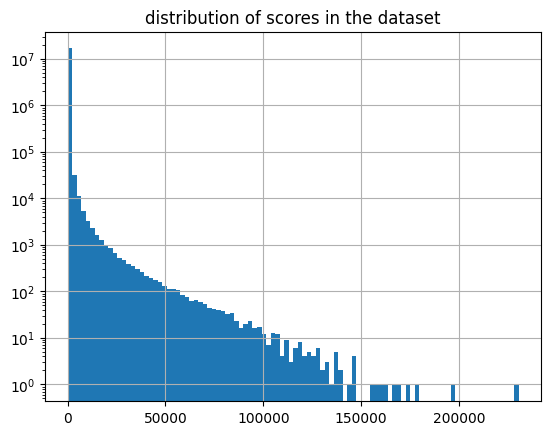

In [30]:
# disable logging
import logging
logging.disable(logging.CRITICAL)

df["score"].hist(bins=100, log=True)
plt.title("distribution of scores in the dataset")

Text(0.5, 1.0, 'distribution of length in the dataset')

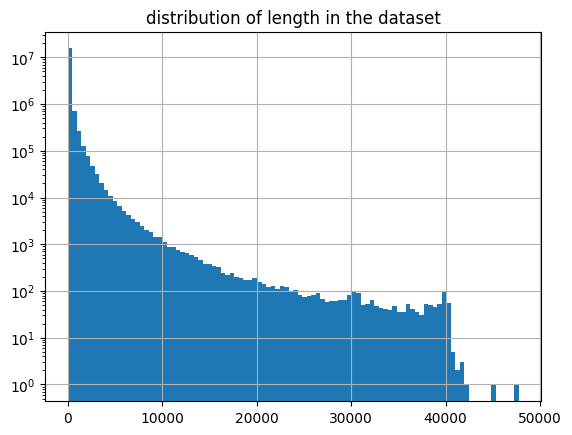

In [31]:
df["length"].hist(bins=100, log=True)
plt.title("distribution of length in the dataset")

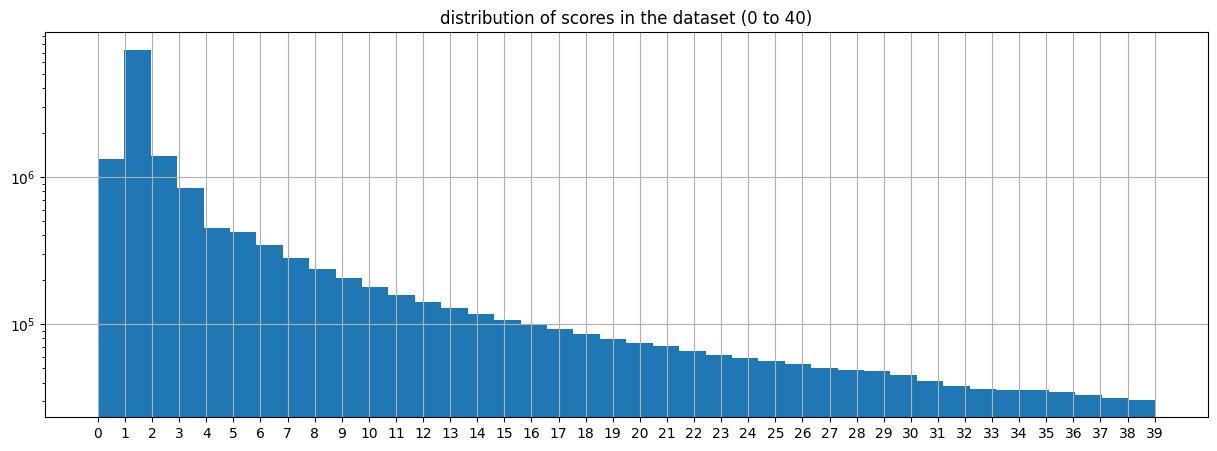

In [32]:
# plot zooming in the range of 0 to 20
max_score = 40
zero_to_20 = df[df["score"] < max_score]
plt.figure(figsize=(15, 5))
zero_to_20["score"].hist(bins=max_score, log=True)
plt.xticks(np.arange(0, max_score, 1.0))
plt.title("distribution of scores in the dataset (0 to 40)")
plt.show()

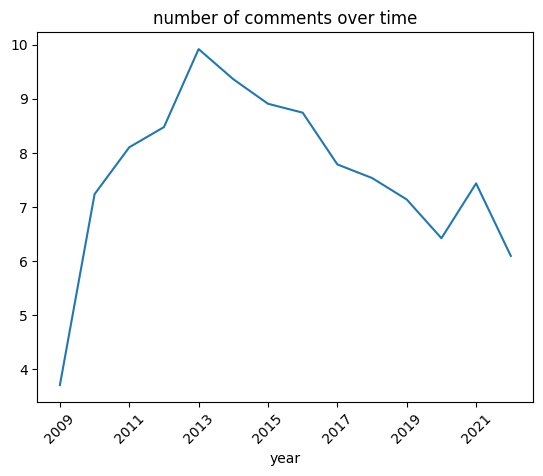

In [33]:
df.groupby("year")["num_comments"].mean().plot()
plt.title("number of comments over time")
plt.xticks(rotation=45)
plt.show()

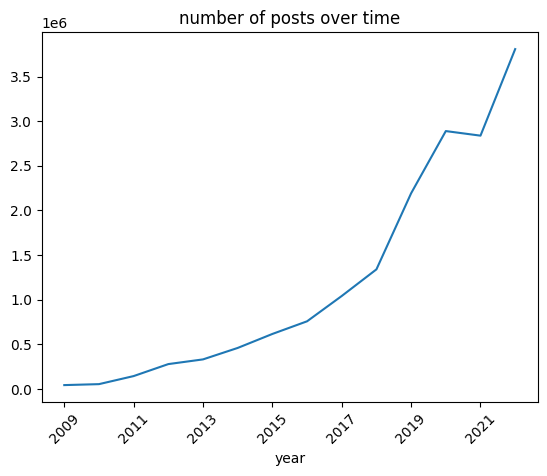

In [34]:
df.groupby("year")["score"].count().plot()
plt.xticks(rotation=45)
plt.title("number of posts over time")
plt.show()

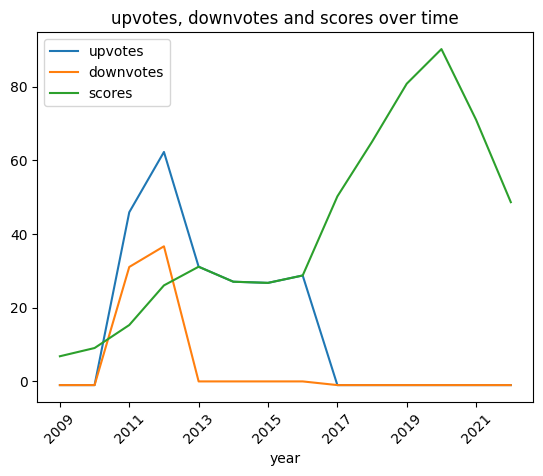

In [35]:
# upvotes downvotes over time
df.groupby("year")["upvotes"].mean().plot(legend=True, label="upvotes")
df.groupby("year")["downvotes"].mean().plot(legend=True, label="downvotes")
df.groupby("year")["score"].mean().plot(legend=True, label="scores")
plt.title("upvotes, downvotes and scores over time")
plt.xticks(rotation=45)
plt.show()

## Observation
we can see a shift in how up votes and downvotes are used. Only for a brief initial perdio downvotes where allowed then either user stopped useing them (probably no) or reddit masked them to zero. From 2013 to 2016 the scores corresponded to the upvotes, then they decoupled and upvotes stopped being reported.  

I'm suprised on how high the mean upvote/score is. The outliers weight a lot. 

Probably beeter to consider data starting from 2011 as before there aren't enough people. 

NOTE: It might be necessary to have different filtering method (e.g. on the score) over time as the meaning of a certain score seems to change. 

In [36]:

total_posts = df.groupby(["subreddit", "year"])["score"].count()
total_posts = total_posts.reset_index()
total_posts.rename(columns={"score": "total_posts"}, inplace=True)

top_subreddits_per_year = total_posts.groupby('year').apply(
    lambda x: x.nlargest(7, 'total_posts')
).reset_index(drop=True)

# remove columns with only one value different from nan 
subreddits_count = top_subreddits_per_year.subreddit.value_counts()
subreddits_count = subreddits_count[subreddits_count > 1].index
top_subreddits_per_year = top_subreddits_per_year[top_subreddits_per_year.subreddit.isin(subreddits_count)]
top_subreddits_per_year

/tmp/ipykernel_969711/2741721017.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_subreddits_per_year = total_posts.groupby('year').apply(


subreddit  year  total_posts
0       reddit.com  2009        19862
1         politics  2009         2008
2             pics  2009         1792
3            funny  2009         1294
4              WTF  2009         1106
..             ...   ...          ...
89       teenagers  2021        12564
91       AskReddit  2022        29760
92     GaySnapchat  2022        25796
96    dirtykikpals  2022        18688
97  u_toronto_news  2022        18081

[79 rows x 3 columns]

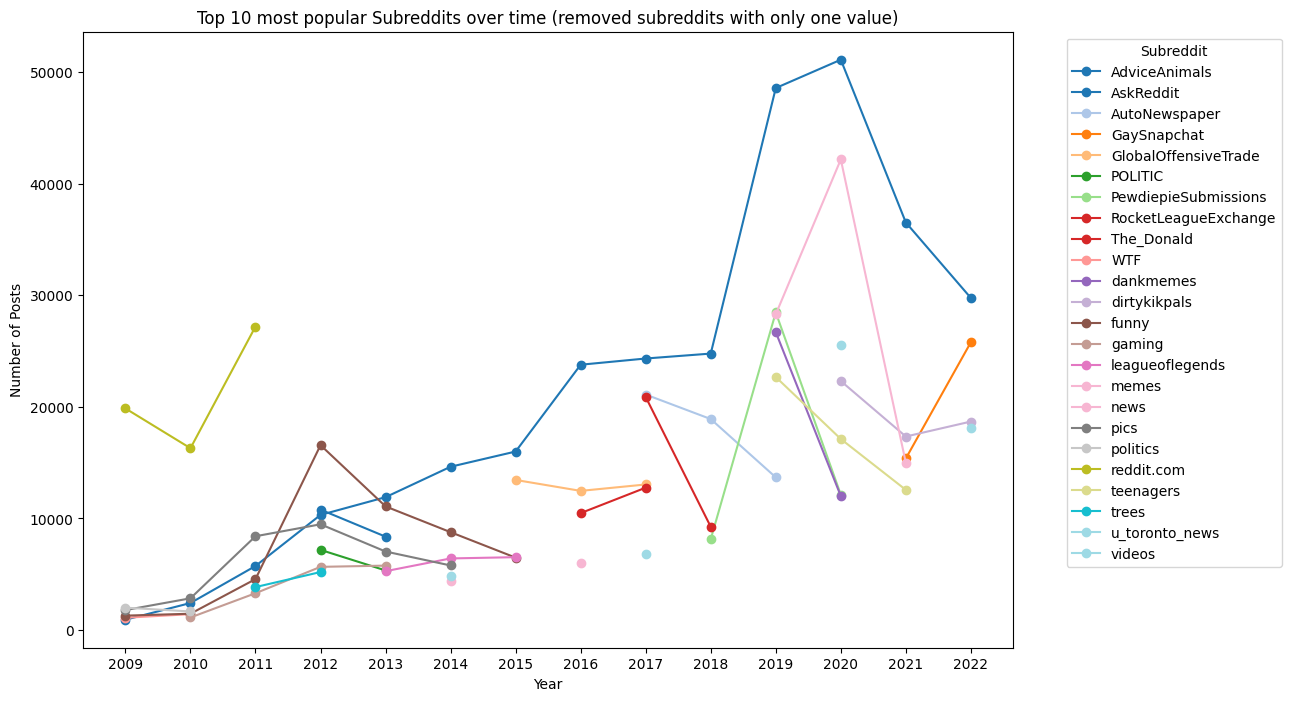

In [37]:

import matplotlib

pivot_df = top_subreddits_per_year.pivot(index='year', columns='subreddit', values='total_posts')

plt.figure(figsize=(12, 8))
colors = matplotlib.pyplot.get_cmap('tab20', len(pivot_df.columns))

for i, column in enumerate(pivot_df.columns):
    plt.plot(pivot_df.index, pivot_df[column], marker='o', label=column, color=colors(i))


plt.title('Top 10 most popular Subreddits over time (removed subreddits with only one value)')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.legend(title='Subreddit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


NOTE: in order to make computation faster after 2013 we're only considering the first 3 millions post for each month. 

In [24]:
print("Number of posts with media: ", df.has_media.sum(), "percentage: ", df.has_media.mean())

Number of posts with media:  3524977 percentage:  0.10012890437811875


# Testing full pipeline in notebook

In [5]:
import psycopg2

db_config = {
    "dbname": "reddit_db",
    "user": "stefanoviel",
    "password": "pass",
    "host": "localhost"
}


conn = psycopg2.connect(**db_config)
cursor = conn.cursor()  # Server-side cursor

query = f"SELECT title, selftext, subreddit FROM food_movies"
cursor.execute(query)
rows = cursor.fetchall()
sentences = [row[0] + " " + row[1] for row in rows]

In [7]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
import hdbscan

# Load the model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Compute embeddings
embeddings = model.encode(sentences)
embeddings.shape

/media/data/stviel/RedditPolarization/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/media/data/stviel/RedditPolarization/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(29319, 384)

In [41]:
from cuml.manifold import UMAP
import numpy as np

local_model = UMAP(n_neighbors=3,n_components=5,min_dist=0.01)
fit_transformed = local_model.fit_transform(embeddings)

local_model = UMAP(n_neighbors=3,n_components=5,min_dist=0.01)
fit_and_transformed = local_model.fit(embeddings).transform(embeddings)


local_model = UMAP(n_neighbors=3,n_components=5,min_dist=0.01)
indices = np.arange(len(embeddings))
shuffled_indices = np.random.permutation(indices)
shuffled_embeddings = embeddings[shuffled_indices]

# Fit the model on the original embeddings and transform the shuffled embeddings
transformed_shuffled = local_model.fit(embeddings).transform(shuffled_embeddings)

# Reorder the transformed embeddings back to their original order
# Create an array to place the transformed data in original order
fit_and_transformed_shuffled = np.empty_like(transformed_shuffled)
fit_and_transformed_shuffled[shuffled_indices] = transformed_shuffled

print(cuml.metrics.trustworthiness(fit_transformed, fit_and_transformed)) 
print(cuml.metrics.trustworthiness(fit_transformed, fit_and_transformed_shuffled))
print(cuml.metrics.trustworthiness(fit_and_transformed, fit_and_transformed_shuffled))

0.9689263365264463
0.9875684470794206
0.9715264066436897


Both fit and transform have stocasticity. The results change if we call the functino multiple time on the same dataset. Having higher `negative_sample_rate` can make result more reliable (as suggested here: https://github.com/lmcinnes/umap/issues/268), negative sample are the potential edges which weren't present in the original graph. 

## Interesting observation on trustworthiness

The lines show the trustworthiness of the dimensionality reducted dataset (fitted with different subset of the data) computed in comparison with the original dataset and the dimensionality reducted one fitted on the whole dataset. 

explanation on how transform works: https://github.com/lmcinnes/umap/issues/384

NOTE: performances changes a from n neighbor = 2 to 3. There is stocasticity in finding the neighbors (they don't check all the combinations of nodes), having only two probably makes it very unstable.

ANOTHER useful thread (explain shuffle): https://github.com/lmcinnes/umap/issues/268 

# comparing trustworthiness

Trustworthiness for ../output/testing_pipeline_1/test_percentage_subset/subset_0.001.h5: 0.6859294413439646
Trustworthiness for ../output/testing_pipeline_1/test_percentage_subset/subset_0.01.h5: 0.7696362544011751
Trustworthiness for ../output/testing_pipeline_1/test_percentage_subset/subset_0.1.h5: 0.8256720479964542
Trustworthiness for ../output/testing_pipeline_1/test_percentage_subset/subset_0.2.h5: 0.8435122260240786
Trustworthiness for ../output/testing_pipeline_1/test_percentage_subset/subset_0.4.h5: 0.8665891326707192
Trustworthiness for ../output/testing_pipeline_1/test_percentage_subset/subset_0.6.h5: 0.8866840283835483
Trustworthiness for ../output/testing_pipeline_1/test_percentage_subset/subset_0.8.h5: 0.9160345763922151
Trustworthiness for ../output/testing_pipeline_1/test_percentage_subset/subset_0.9.h5: 0.9360337352106575
Trustworthiness for ../output/testing_pipeline_1/test_percentage_subset/subset_0.9999.h5: 0.964438214391486
Trustworthiness for ../output/testing_pip

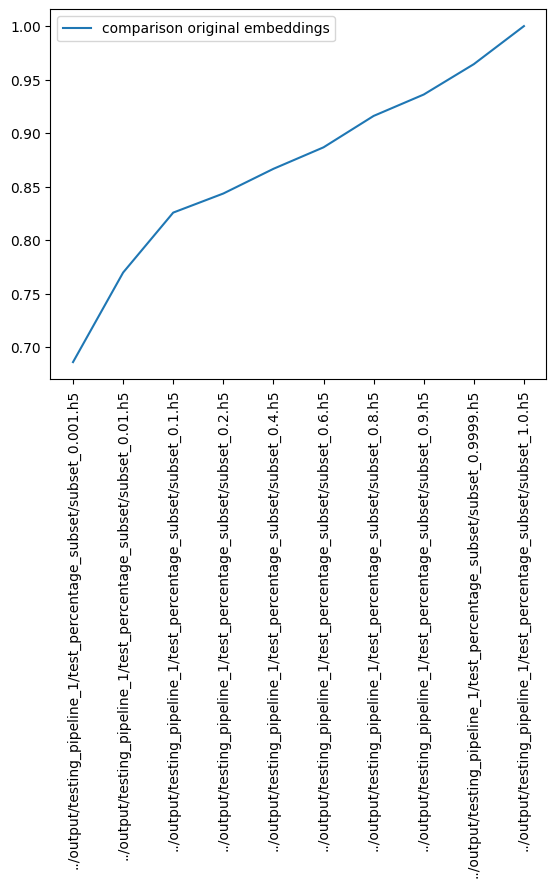

In [68]:
original_file = '../output/testing_pipeline_1/embeddings.h5'
original_dataset_name = 'data'

label_files_directory = '../output/testing_pipeline_1/test_percentage_subset'
label_dataset_name = "umap_coordinates"

# disable logging of debug
import logging
logging.getLogger().setLevel(logging.INFO)

# compute_plot_trutworthiness(original_file, original_dataset_name, reduced_files_directory, reduced_dataset_name, label="comparison fitting full sample")

original_file = '../output/testing_pipeline_1/test_percentage_subset/subset_1.0.h5'
original_dataset_name = 'data'

compute_plot_trutworthiness(original_file, original_dataset_name, label_files_directory, label_dataset_name, label="comparison original embeddings")

plt.xticks(rotation=90)
plt.show()

### How does the number of output dimension of the dimensionality reduction affect performance

In [3]:
import re
from src.utils.plots import compute_plot_trutworthiness

original_file = '../output/testing_pipeline_1/embeddings.h5'
original_dataset_name = 'data'

label_files_directory = '../output/testing_pipeline_1/test_embed_n_components'
label_dataset_name = "umap_coordinates"

trustworthiness_scores_original = compute_plot_trutworthiness(original_file, original_dataset_name, label_files_directory, label_dataset_name, plot=False)

# Extract the number of components from the file paths
n_components = []
for path, tw in trustworthiness_scores_original.items():
    match = re.search(r"components_(\d+)", path)
    n_components.append(int(match.group(1)))

# Plotting
paired_list = sorted(zip(n_components, list(trustworthiness_scores_original.values())))
sorted_first_list, sorted_second_list = zip(*paired_list)
sorted_first_list, sorted_second_list
plt.plot(sorted_first_list,sorted_second_list, label="Comparison with original")
plt.xticks(sorted_first_list)
plt.show()

Trustworthiness for ../output/testing_pipeline_1/test_embed_n_components/components_10.h5: 0.9745609209204077
Trustworthiness for ../output/testing_pipeline_1/test_embed_n_components/components_15.h5: 0.9762329213840777


KeyboardInterrupt: 

Performances increase quite quickly from two to three dimensions from two to 5, then start decreasing from 15. Maybe due to the curse of dimensionality?  
Proably something with umap which only work with low dimensions. 

# How does it look in 2D? 

In [83]:
import psycopg2

db_config = {
    "dbname": "reddit_db",
    "user": "stefanoviel",
    "password": "pass",
    "host": "localhost"
}


conn = psycopg2.connect(**db_config)
cursor = conn.cursor()  # Server-side cursor
query = f"SELECT subreddit FROM food_movies;"

cursor.execute(query)
rows = cursor.fetchall()

In [84]:
category = [row[0] for row in rows]

# convert categories to numbers (e.g. 0, for food, 1 for movies)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(category)
category = le.transform(category)
category

array([1, 0, 1, ..., 1, 0, 0])

In [85]:
import plotly.express as px

reduced_01 = load_vectors('../output/testing_pipeline/food_movies_diff_dimensions/components_2.h5', 'data')

# Creating the Plotly scatter plot with zoom and pan functionality
fig = px.scatter(x=reduced_01[:, 0], y=reduced_01[:, 1], color=category,
                 color_continuous_scale='Viridis', title='Interactive Scatter Plot',
                 labels={'x': 'Component 1', 'y': 'Component 2', 'color': 'Category'})

# make figure a square
fig.update_layout(width=800, height=800)

fig.update_traces(marker=dict(size=5))  # Adjusting marker size for better visibility
fig.show()


One category are posts in r/movies the other r/food

# clustering comparison

ground truth 163072
subset_0.001.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.001.h5 number of unique predictedlabels: 41
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.001.h5: 0.029226797662564228
subset_0.01.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.01.h5 number of unique predictedlabels: 77
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.01.h5: 0.1707906040783421
subset_0.1.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.1.h5 number of unique predictedlabels: 184
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.1.h5: 0.2635382858720581
subset_0.2.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.2.h5 number of unique predictedlabels: 180
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.2.h5: 0.30864804196745005
subset_0.4.h5 ../o

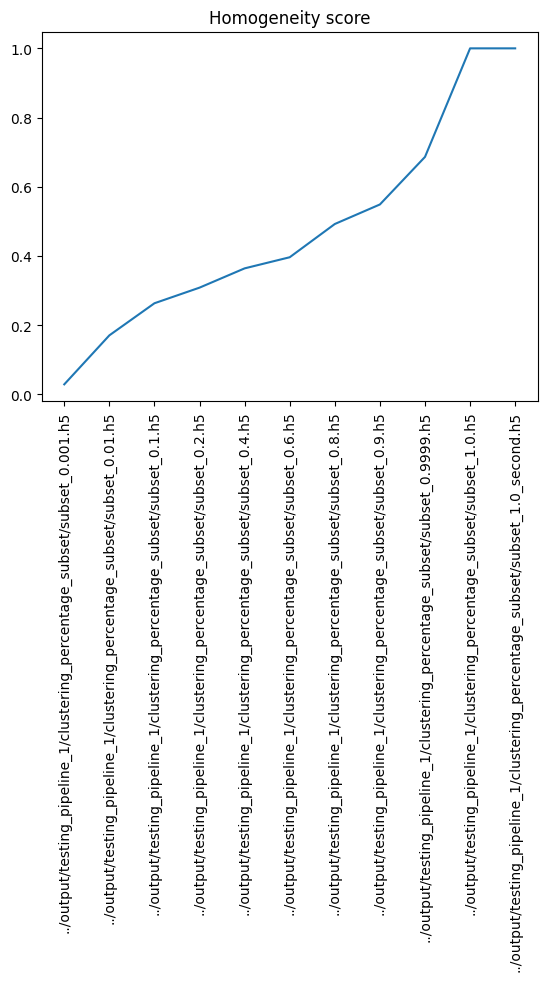

In [9]:
original_file = '../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5'
original_dataset_name = 'data'

label_files_directory = '../output/testing_pipeline_1/clustering_percentage_subset'
label_dataset_name = "clusters"


# disable logging of debug
import logging

import sklearn.metrics
logging.getLogger().setLevel(logging.INFO)

ari_score = match_and_compute_cluster_metrics(sklearn.metrics.v_measure_score, original_file, original_dataset_name, label_files_directory, label_dataset_name)
plt.plot(ari_score.keys(), ari_score.values())
plt.xticks(rotation=90)
plt.title("Homogeneity score")
plt.show()

ground truth 163072
subset_0.001.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.001.h5 number of unique predictedlabels: 41
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.001.h5: 0.012086005137873125
subset_0.01.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.01.h5 number of unique predictedlabels: 77
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.01.h5: 0.031057415122418844
subset_0.1.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.1.h5 number of unique predictedlabels: 184
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.1.h5: 0.053138781788294454
subset_0.2.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.2.h5 number of unique predictedlabels: 180
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.2.h5: 0.07804398272450892
subset_0.4.h5 

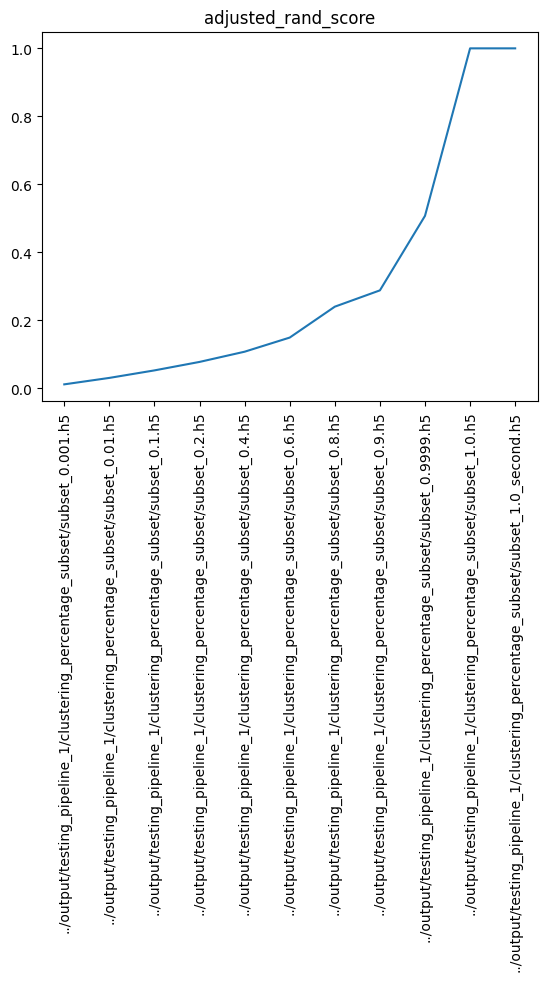

In [10]:
original_file = '../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5'
original_dataset_name = 'data'

label_files_directory = '../output/testing_pipeline_1/clustering_percentage_subset'
label_dataset_name = "clusters"


# disable logging of debug
import logging
logging.getLogger().setLevel(logging.INFO)

ari_score = match_and_compute_cluster_metrics(sklearn.metrics.adjusted_rand_score, original_file, original_dataset_name, label_files_directory, label_dataset_name)
plt.plot(ari_score.keys(), ari_score.values())
plt.xticks(rotation=90)
plt.title("adjusted_rand_score")
plt.show()


ground truth 163072
subset_0.001.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.001.h5 number of unique predictedlabels: 41
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.001.h5: 0.0287292288747872
subset_0.01.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.01.h5 number of unique predictedlabels: 77
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.01.h5: 0.16812461337342768
subset_0.1.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.1.h5 number of unique predictedlabels: 184
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.1.h5: 0.25867973908793623
subset_0.2.h5 ../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5
subset_0.2.h5 number of unique predictedlabels: 180
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.2.h5: 0.30353864555406007
subset_0.4.h5 ../o

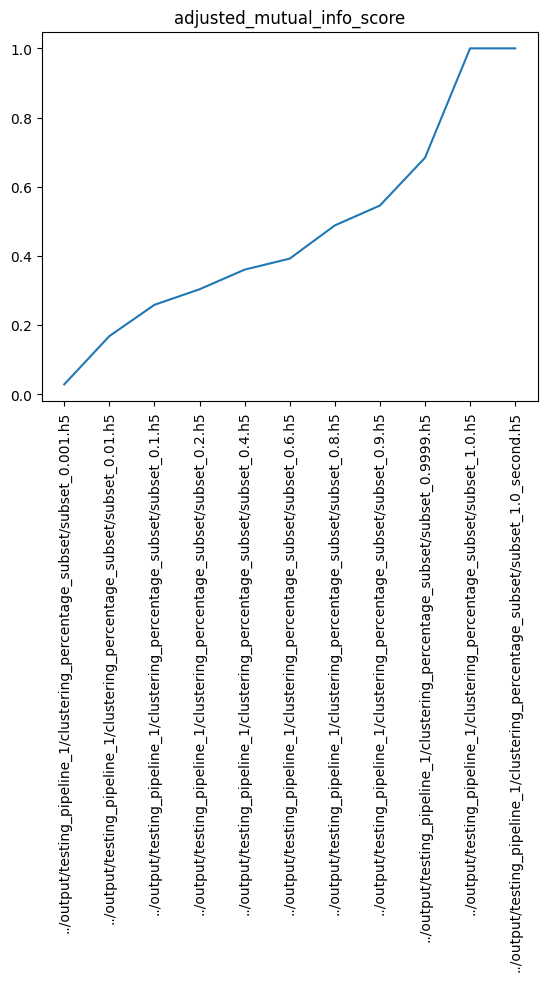

In [11]:
original_file = '../output/testing_pipeline_1/clustering_percentage_subset/subset_1.0.h5'
original_dataset_name = 'data'

label_files_directory = '../output/testing_pipeline_1/clustering_percentage_subset'
label_dataset_name = "clusters"


# disable logging of debug
import logging
logging.getLogger().setLevel(logging.INFO)

ari_score = match_and_compute_cluster_metrics(sklearn.metrics.adjusted_mutual_info_score, original_file, original_dataset_name, label_files_directory, label_dataset_name)
plt.plot(ari_score.keys(), ari_score.values())
plt.xticks(rotation=90)
plt.title("adjusted_mutual_info_score")
plt.show()

subset_0.001.h5 number of unique predictedlabels: 40
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.001.h5: -0.21149630844593048
subset_0.01.h5 number of unique predictedlabels: 76
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.01.h5: -0.24188069999217987
subset_0.1.h5 number of unique predictedlabels: 183
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.1.h5: -0.21677744388580322
subset_0.2.h5 number of unique predictedlabels: 179
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.2.h5: -0.13925668597221375
subset_0.4.h5 number of unique predictedlabels: 141
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.4.h5: -0.04076823592185974
subset_0.6.h5 number of unique predictedlabels: 136
ADJ for ../output/testing_pipeline_1/clustering_percentage_subset/subset_0.6.h5: 0.001518728444352746
subset_0.8.h5 number of unique predictedlabels: 146
ADJ for ../output/te

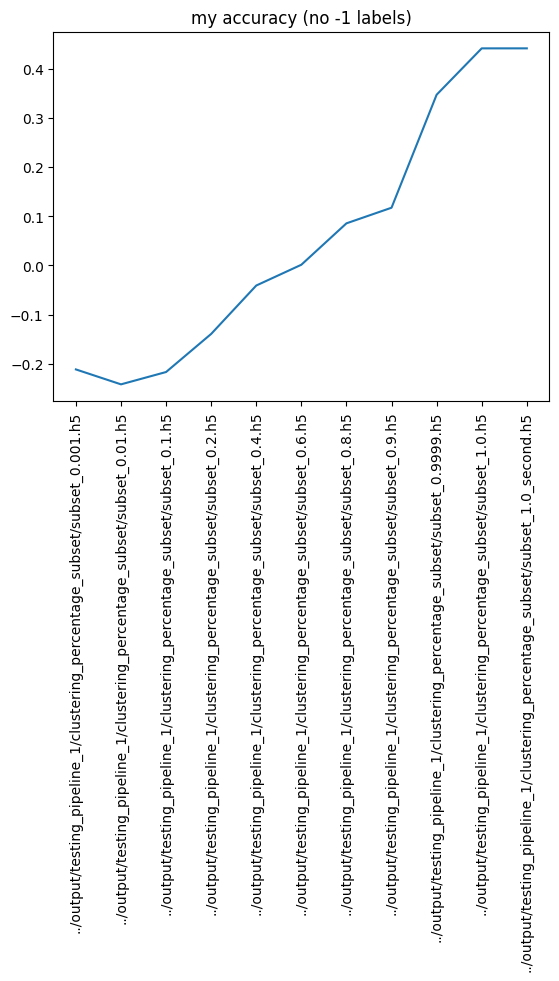

In [12]:
import cuml.metrics


original_file = '../output/testing_pipeline_1/test_percentage_subset/subset_1.0.h5'
original_dataset_name = 'data'

label_files_directory = '../output/testing_pipeline_1/clustering_percentage_subset'
label_dataset_name = "clusters"

embeddings = load_vectors(original_file, original_dataset_name)        


ari_scores = {}


for file in os.listdir(label_files_directory):
    if file.endswith('.h5'):
        file_path = os.path.join(label_files_directory, file)
        predicted_labels = load_vectors(file_path, label_dataset_name)
        
        # remove embeddings with -1 labels
        mask = predicted_labels != -1
        predicted_labels = predicted_labels[mask]
        processed_embeddings = embeddings[mask]

        print(file, "number of unique predictedlabels:", len(np.unique(predicted_labels)))

        ari = cuml.metrics.cluster.silhouette_score(processed_embeddings, predicted_labels)
        print(f'ADJ for {file_path}: {ari}')
        ari_scores[file_path] = ari

plt.plot(ari_scores.keys(), ari_scores.values())
plt.xticks(rotation=90)
plt.title("my accuracy (no -1 labels)")
plt.show()

The problem seems to be that there is a lot of stocasticity in how these cluster are computed. 

It depends a lot on the parameters used in the clustering (min sample, min cluster size). 
* Higher values of min cluster size will decrease the number of clusters => higher score. 
* Higher values of min number of samples to be considered a core node will decrease the number of core nodes and clusters => higher scores

It should only get better with more data as the points get more dense? Not sure. There will be more core points maybe more clusters. \

How do I make it as robust as possible? quantify robustness: 0.999 and 1.0 should be as close as possible. Grid search on different hyperparameter to find the closest one. 

Where does the randomicity in clustering comes from? There is no randomicity in clustering. It all comes from the dimensionality reduction. 

# Silhouette score

In [7]:
import os
import sys

# adding root directory to paths
sys.path.append('../')

try:
    from src.hdbscan import run_hdbscan_search_best_silhouette, plot_silhouette_heatmap
except Exception as e:
    pass



silhouette_scores = run_hdbscan_search_best_silhouette(config.)
plot_silhouette_heatmap(silhouette_scores)

NameError: name 'run_hdbscan_search_best_silhouette' is not defined